# Fair Policies
In this part of the project we will work on how to measure whether our policy is fair. In this particular task, we have chosen the random policy that already exists in the data set. To measure the fairness of the policy, we have chosen to use calibration 

$$P_\theta ^{\pi} (y|a,z) = P_\theta ^{\pi} (y|a)$$
In other words, we first train our classifier $\pi_0$ with action data $a$ and sensitive variables $z$ as input and outcome data $y$ as response. Then we train a new classifier $\pi_1$ again with action data without sensitive variables as input and outcome data $y$ as response. In order to calculate the fairness measure, we use 
$$ \sum_i \Big | P_\theta ^{\pi} (y|a,z) - P_\theta ^{\pi} (y|a) \Big | $$

We want this measure to as low as possible for all outcomes in order to declare it fair. The sensitive variable is chosen to be the age of the pasients. We have the data into two groups, e.g. young and old people.

## Loading the data

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import random
random.seed(10)

In [3]:
treat_data = pd.read_csv("treatment_features.csv",header=None)
action_data = pd.read_csv("treatment_actions.csv",header=None)
outcome_data = pd.read_csv("treatment_outcomes.csv",header=None)

symptoms_names = ['Covid-Recovered', 'Covid-Positive', 'No-Taste-Smell', 'Fever', 'Headache', 
                  'Pneumonia', 'Stomach', 'Myocarditis', 'Blood-Clots', 'Death','Age', 'Gender', 'Income']
cols = ( symptoms_names +
         [f'Gene_{i+1:03}' for i in range(128)] +
         ['Asthma', 'Obesity', 'Smoking', 'Diabetes', 'Heart disease', 'Hypertension',
         'Vacc_1', 'Vacc_2', 'Vacc_3'])

treat_data.columns = cols
outcome_data.columns = cols[:10]
action_data.columns = ['Treatment_1', 'Treatment_2']

## Histograms for treatment
We are interesed in discovering how the symptoms vary with the *young* and the *old* age category before and after the given actions (treatments). The plots below gives an overview. 

In [33]:
#Dividing the age -> (0,1) based on the mean of the age.
treat_data1 = treat_data.assign(age_cat = pd.cut(treat_data["Age"], (treat_data['Age'].min(),treat_data['Age'].mean(), treat_data["Age"].max()), labels=[0, 1]))

In [66]:
def bootstrap_and_plot(symptom_name, treat_data = treat_data1, outcome_data = outcome_data,action_nr=None):
    age_cat = treat_data1['age_cat']
    boot_samples_before = pd.DataFrame([
        treat_data1.sample(treat_data1.shape[0], replace=True).
        groupby('age_cat')[symptom_name].mean()
        for _ in range(1000)])
    
    outcome_age = pd.concat([outcome_data,age_cat], axis=1)
    boot_samples_after = pd.DataFrame([
    outcome_age.sample(outcome_age.shape[0], replace=True).
    groupby('age_cat')[symptom_name].mean()
    for _ in range(1000)])
    
    fig, axes = plt.subplots(nrows=1, ncols=2)

    boot_samples_before.plot.hist(bins=30,alpha=0.5,ax=axes[0])
    boot_samples_after.plot.hist(bins=30,alpha=0.5,ax=axes[1])

    
    axes[0].title.set_text(f'Before action {action_nr}')
    axes[1].title.set_text(f'After action {action_nr}')
    
    axes[0].set_xlabel(f'Mean {symptom_name}')
    axes[1].set_xlabel(f'Mean {symptom_name}')

    fig.savefig(f"/Users/roaka001/Documents/OneDrive/IN-STK5000/fairness_and_privacy/figs_fairness/{symptom_name}_{action_nr}.png")

In [49]:
symptom_lst = ['Covid-Recovered', 'Covid-Positive', 'No-Taste-Smell', 'Fever', 'Headache', 'Pneumonia', 'Stomach', 'Myocarditis', 'Blood-Clots', 'Death']
for s in symptom_lst:
    #bootstrap_and_plot(s)
    pass

## Splitting into two groups by actions

In [63]:
X = treat_data
Y = outcome_data
a = action_data

X1 = X[a.iloc[:,0]==1]
X2 = X[a.iloc[:,1]==1]
y1 = Y[a.iloc[:,0]==1]
y2 = Y[a.iloc[:,0]==1]

#Dividing the age -> (0,1) based on the mean of the age.
X1_new = X1.assign(age_cat = pd.cut(X1["Age"], (X1['Age'].min(),X1['Age'].mean(), X1["Age"].max()), labels=[0, 1]))
X2_new = X2.assign(age_cat = pd.cut(X2["Age"], (X2['Age'].min(),X2['Age'].mean(), X2["Age"].max()), labels=[0, 1]))

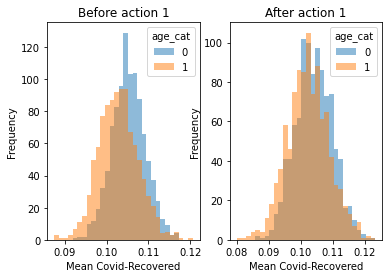

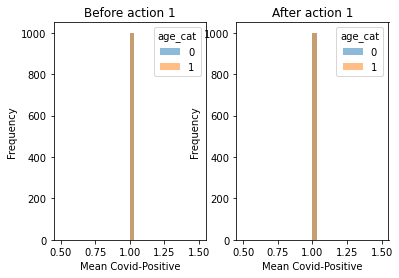

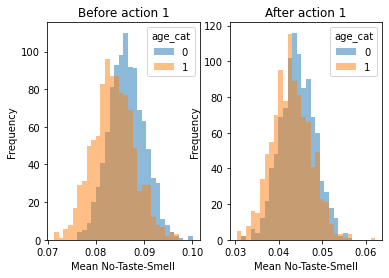

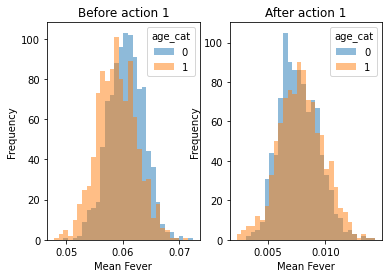

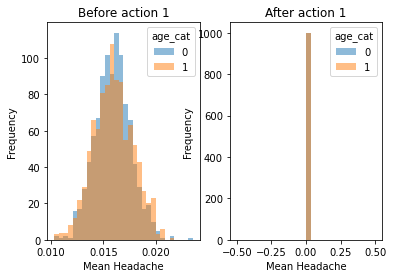

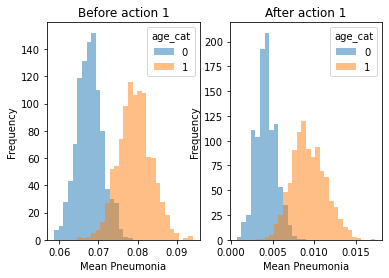

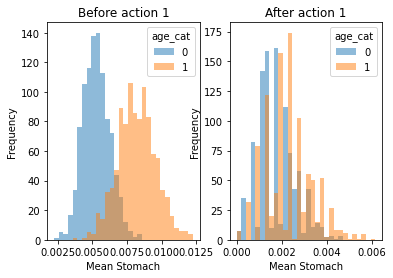

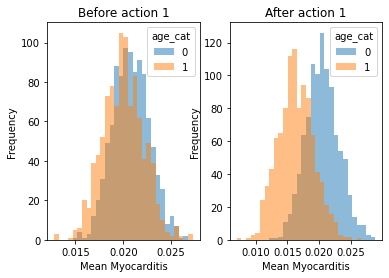

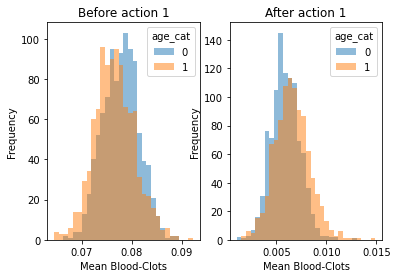

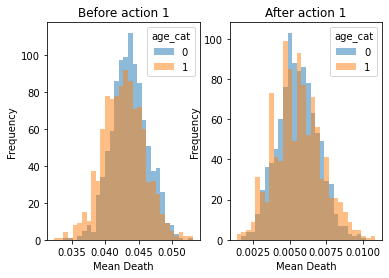

In [68]:
symptom_lst = ['Covid-Recovered', 'Covid-Positive', 'No-Taste-Smell', 'Fever', 'Headache', 'Pneumonia', 'Stomach', 'Myocarditis', 'Blood-Clots', 'Death']
for s in symptom_lst:
    bootstrap_and_plot(s,treat_data=X1_new,outcome_data=y1,action_nr=1)

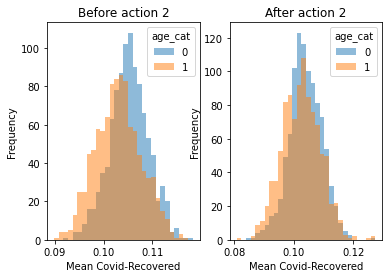

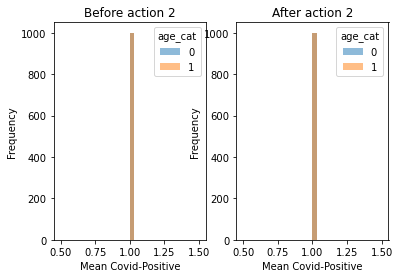

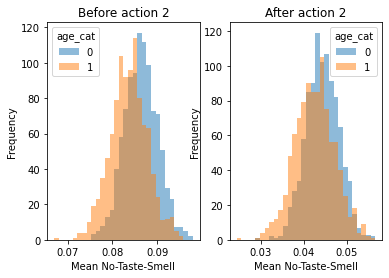

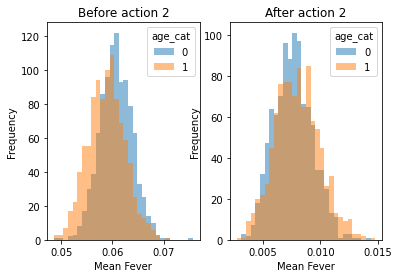

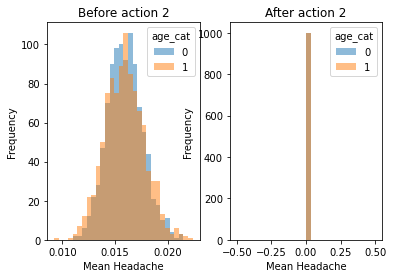

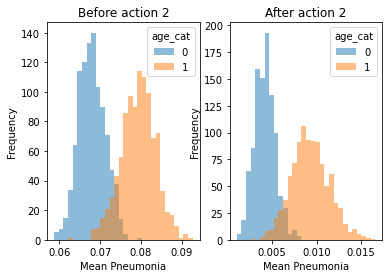

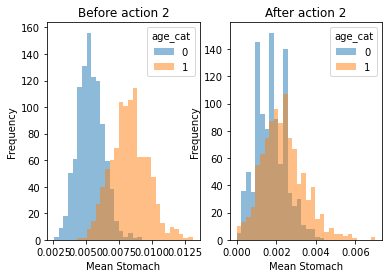

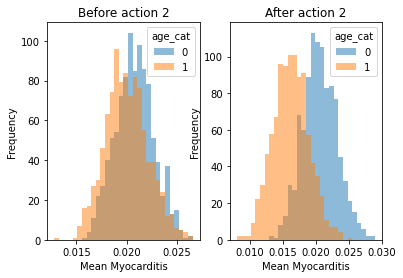

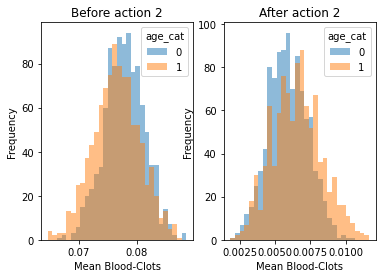

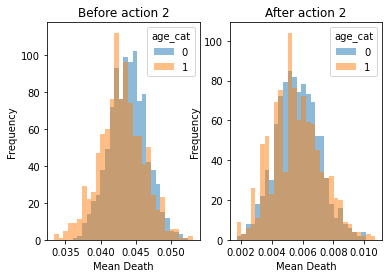

In [69]:
for s in symptom_lst:
    bootstrap_and_plot(s,treat_data=X2_new,outcome_data=y2,action_nr=2)

## Finding probabilities
In this section, we will compute the probabilities of $P_\theta ^{\pi} (y|a,z)$ and $P_\theta ^{\pi} (y|a)$.

In [14]:
#Dividing the age -> (0,1)
treat_data1 = treat_data.assign(age_cat = pd.cut(treat_data["Age"], (treat_data['Age'].min(),treat_data['Age'].mean(), treat_data["Age"].max()), labels=[0, 1]))

In [15]:
symptoms_names.append('age_cat')

In [16]:
## setting the age category to be the sensitive variable
age_cat = treat_data1['age_cat']

In [17]:
#setting actions and age_cat together:
total_data = pd.concat([action_data, age_cat,outcome_data], axis=1) 
total_data = total_data.dropna()

X = total_data.iloc[:,0:3]
Y = total_data.iloc[:,3:]

In [18]:
#splitting the data into training and test
X1_tr, X1_ts, Y1_tr,Y1_ts = train_test_split(X,Y,test_size=0.33,random_state=1) 

In [19]:
def train_pred(X_tr,X_ts,Y_tr,Y_ts):
    scaler = StandardScaler().fit(X_tr)
    X_tr = scaler.transform(X_tr)
    scaler.fit(X_ts)
    X_ts = scaler.transform(X_ts)

    #training
    mlp = MLPClassifier(activation='logistic', max_iter=10_000)
    mlp.fit(X_tr,Y_tr)

    #predicitng
    y_hat = mlp.predict(X_ts)
    #return accuracy_score(Y_ts, y_hat),mlp
    
    return mlp.predict_proba(X_ts)

In [20]:
#predicting action_data with z
prob_z = train_pred(X1_tr,X1_ts,Y1_tr,Y1_ts)

In [21]:
## doing the same but without the z
total_data = pd.concat([action_data,outcome_data], axis=1) 
total_data = total_data.dropna()

X_non_z = total_data.iloc[:,0:2]
Y_non_z = total_data.iloc[:,2:]

X_tr, X_ts, Y_tr,Y_ts = train_test_split(X_non_z,Y_non_z,test_size=0.33,random_state=1) 

#predicting action_data without z
prob_non_z = train_pred(X_tr, X_ts, Y_tr,Y_ts)

# Computing the fairness

In [22]:
diff = np.abs(prob_non_z-prob_z)
fairness_df = pd.DataFrame(np.sum(diff,axis =0),).T
fairness_df.columns = ['Covid-Recovered', 'Covid-Positive', 'No-Taste/Smell', 'Fever', 'Headache', 'Pneumonia', 'Stomach', \
                       'Myocarditis', 'Blood-Clots', 'Death',]
fairness_df.index = ['Fairness:']
fairness_df

,Covid-Recovered,Covid-Positive,No-Taste/Smell,Fever,Headache,Pneumonia,Stomach,Myocarditis,Blood-Clots,Death
Fairness:,6.638951,0.685614,22.057378,47.492659,1.669986,69.627222,3.624037,5.510939,28.667796,30.763775


The dataframe above shows the initial fairness of the symptoms using our basic policy. As mentioned above, we want this fairness values to be as low as possible. We can for example see for symptoms like *Headache* that the fainess value is very small which means that the pasients with this symptoms get very fair treatment regardless of age category. Now we want to find a policy that minimizes the initial fairness values for all symptoms.